# 1D Kalman Filter

In [21]:

# Simulated ground truth: car starts at 0 and moves at 1 m/s
dt = 1.0  # time step (seconds)
true_velocity = 1.0
steps = 50

# Arrays to store values
true_positions = []
measurements = []
estimates = []

In [22]:
# Initial guess
x_est = 0.0   # initial estimated position
P = 1.0       # initial uncertainty

# Noise settings
Q = 0.01  # process noise (model uncertainty)
R = 4.0   # measurement noise (sensor uncertainty, GPS)

for t in range(steps):
    # --- True motion ---
    true_pos = true_velocity * t
    true_positions.append(true_pos)

    # --- Simulated noisy GPS measurement ---
    z = true_pos + np.random.normal(0, np.sqrt(R))
    measurements.append(z)

    # --- Prediction step ---
    x_pred = x_est + true_velocity * dt
    P_pred = P + Q

    # --- Update step ---
    K = P_pred / (P_pred + R)
    x_est = x_pred + K * (z - x_pred)
    P = (1 - K) * P_pred

    estimates.append(x_est)


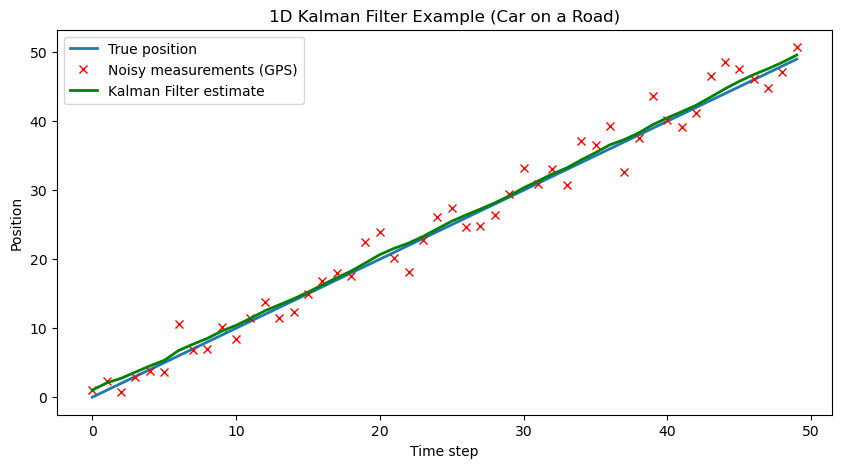

In [3]:
plt.figure(figsize=(10,5))
plt.plot(true_positions, label="True position", linewidth=2)
plt.plot(measurements, 'rx', label="Noisy measurements (GPS)")
plt.plot(estimates, 'g-', label="Kalman Filter estimate", linewidth=2)
plt.xlabel("Time step")
plt.ylabel("Position")
plt.legend()
plt.title("1D Kalman Filter Example (Car on a Road)")
plt.show()

# Kalman Filter with a 2-state model: position & velocity (constant-velocity motion)

In [12]:
# -----------------------------
# Simulation settings
# -----------------------------
dt = 1.0                 # time step (s)
steps = 60               # number of steps
true_init_pos = 0.0
true_init_vel = 1.2      # m/s (constant velocity ground truth)

R = 4.0                  # variance of position measurement
meas_std = np.sqrt(R)

sigma_a = 0.4            # m/s^2 (unmodeled acceleration noise)
Q = sigma_a**2 * np.array([
    [dt**4/4, dt**3/2],
    [dt**3/2, dt**2   ]
])

# -----------------------------
# Kalman filter model
# -----------------------------
A = np.array([[1, dt],
              [0, 1 ]])     # state transition
H = np.array([[1, 0]])      # measure position only
I = np.eye(2)

x_est = np.array([[0.0],
                  [0.0]])    # [pos, vel]
P = np.eye(2) * 1.0

true_pos, true_vel, meas_pos = [], [], []
est_pos, est_vel = [], []

# Ground truth state
x_true = np.array([[true_init_pos],
                   [true_init_vel]])

for k in range(steps):
    # --- Ground truth motion ---
    x_true = A @ x_true
    true_pos.append(x_true[0,0])   # explicit scalar
    true_vel.append(x_true[1,0])

    # --- Measurement (noisy pos only) ---
    z = x_true[0,0] + np.random.normal(0, meas_std)
    meas_pos.append(z)

    # --- Prediction ---
    x_pred = A @ x_est
    P_pred = A @ P @ A.T + Q

    # --- Update ---
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T / S
    y = z - (H @ x_pred)[0,0]

    x_est = x_pred + K * y
    P = (I - K @ H) @ P_pred

    est_pos.append(x_est[0,0])
    est_vel.append(x_est[1,0])

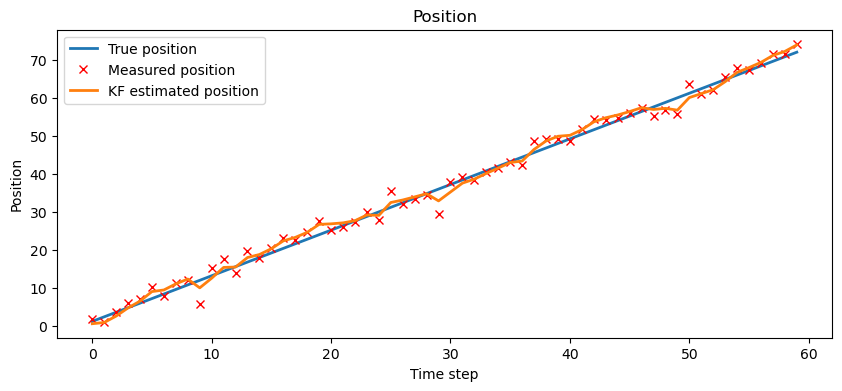

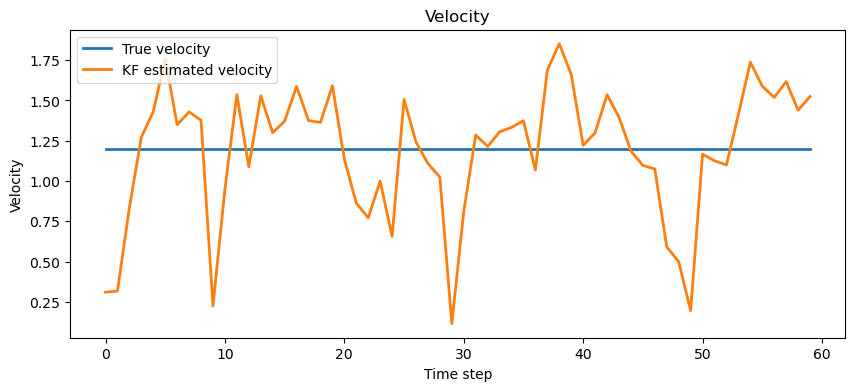

In [14]:
# Plotting
# -----------------------------
plt.figure(figsize=(10,4))
plt.plot(true_pos, label="True position", linewidth=2)
plt.plot(meas_pos, 'rx', label="Measured position")
plt.plot(est_pos, label="KF estimated position", linewidth=2)
plt.xlabel("Time step"); plt.ylabel("Position"); plt.legend(); plt.title("Position")

plt.figure(figsize=(10,4))
plt.plot(true_vel, label="True velocity", linewidth=2)
plt.plot(est_vel, label="KF estimated velocity", linewidth=2)
plt.xlabel("Time step"); plt.ylabel("Velocity"); plt.legend(); plt.title("Velocity")
plt.show()

# EKF (non-linear state)

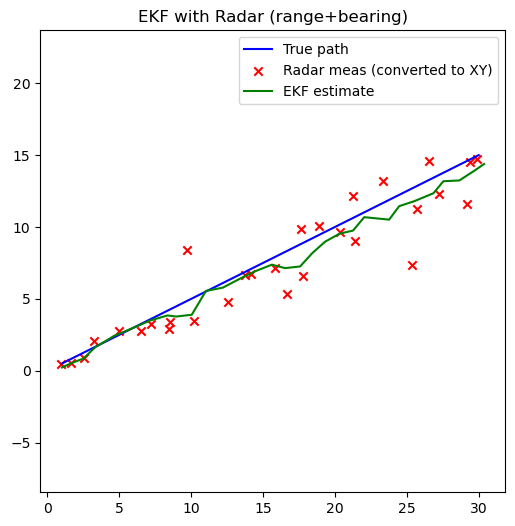

In [15]:
# --- Simulation settings ---
dt = 1.0
steps = 30
true_pos = np.array([0.0, 0.0])  # start at origin
true_vel = np.array([1.0, 0.5])  # vx=1 m/s, vy=0.5 m/s

# --- Noise settings ---
R = np.diag([0.5**2, (np.deg2rad(5))**2])  # radar noise: range=0.5m, angle=5°
Q = np.eye(4) * 0.01  # process noise

# --- EKF state: [x, y, vx, vy] ---
x_est = np.array([0, 0, 0.5, 0])  # initial guess
P = np.eye(4)

# Storage
estimates, truths, meas = [], [], []

for k in range(steps):
    # --- Ground truth motion (constant velocity) ---
    true_pos += true_vel * dt
    truths.append(true_pos.copy())

    # --- Simulated radar measurement (range, angle) ---
    r = np.sqrt(true_pos[0]**2 + true_pos[1]**2)
    theta = np.arctan2(true_pos[1], true_pos[0])
    z = np.array([r, theta]) + np.random.multivariate_normal([0,0], R)
    meas.append(z)

    # --- Prediction ---
    A = np.array([[1, 0, dt, 0],
                  [0, 1, 0, dt],
                  [0, 0, 1,  0],
                  [0, 0, 0,  1]])
    x_pred = A @ x_est
    P_pred = A @ P @ A.T + Q

    # --- Measurement prediction (nonlinear) ---
    px, py, vx, vy = x_pred
    r_pred = np.sqrt(px**2 + py**2)
    theta_pred = np.arctan2(py, px)
    z_pred = np.array([r_pred, theta_pred])

    # --- Jacobian of h(x) wrt state ---
    H = np.zeros((2,4))
    if r_pred < 1e-4:
        continue  # avoid divide by zero
    H[0,0] = px / r_pred
    H[0,1] = py / r_pred
    H[1,0] = -py / (r_pred**2)
    H[1,1] = px / (r_pred**2)

    # --- Innovation ---
    y = z - z_pred
    # normalize angle to [-pi,pi]
    y[1] = (y[1] + np.pi) % (2*np.pi) - np.pi

    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)

    x_est = x_pred + K @ y
    P = (np.eye(4) - K @ H) @ P_pred

    estimates.append(x_est[:2].copy())

# Convert to arrays
estimates = np.array(estimates)
truths = np.array(truths)
meas = np.array(meas)

# --- Plot results ---
plt.figure(figsize=(6,6))
plt.plot(truths[:,0], truths[:,1], 'b-', label="True path")
plt.scatter(meas[:,0]*np.cos(meas[:,1]), meas[:,0]*np.sin(meas[:,1]), 
            c='r', marker='x', label="Radar meas (converted to XY)")
plt.plot(estimates[:,0], estimates[:,1], 'g-', label="EKF estimate")
plt.axis("equal"); plt.legend(); plt.title("EKF with Radar (range+bearing)")
plt.show()

# IMU Drift

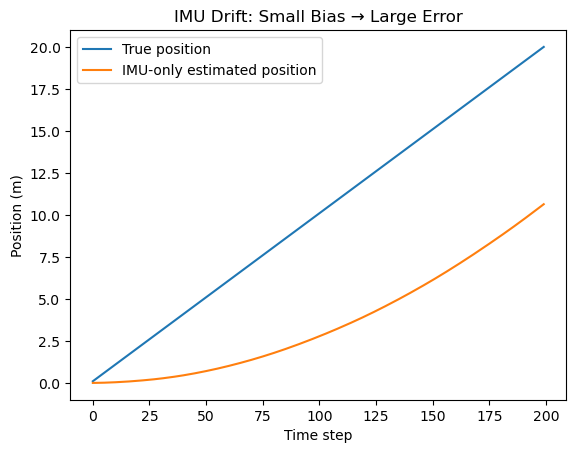

In [16]:
dt = 0.1       # time step (s)
steps = 200    # simulate for 20 seconds
true_acc = 0.0 # car moves at constant velocity (no accel)
true_vel = 1.0 # constant 1 m/s
true_pos = 0.0

# IMU sensor model
acc_bias = 0.05   # small bias in accelerometer (m/s^2)
acc_noise_std = 0.02

# Storage
true_positions, imu_positions = [], []
vel_est, pos_est = 0.0, 0.0

for k in range(steps):
    # True motion (constant velocity)
    true_pos += true_vel * dt
    true_positions.append(true_pos)

    # Simulated IMU measurement
    acc_meas = true_acc + acc_bias + np.random.normal(0, acc_noise_std)

    # Integrate twice (vel -> pos)
    vel_est += acc_meas * dt
    pos_est += vel_est * dt
    imu_positions.append(pos_est)

# Plot
plt.plot(true_positions, label="True position")
plt.plot(imu_positions, label="IMU-only estimated position")
plt.xlabel("Time step")
plt.ylabel("Position (m)")
plt.title("IMU Drift: Small Bias → Large Error")
plt.legend()
plt.show()

# Project 3D -> 2D (image from camera)

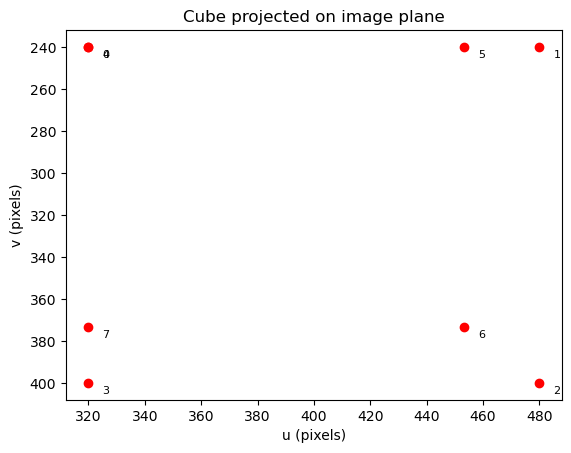

In [17]:
# --- Camera intrinsics ---
fx, fy = 800, 800   # focal length in pixels
cx, cy = 320, 240   # image center (for 640x480 image)
K = np.array([[fx, 0, cx],
              [0, fy, cy],
              [0,  0,  1]])

# --- 3D cube points (X,Y,Z) ---
cube = np.array([[0,0,5],[1,0,5],[1,1,5],[0,1,5],    # front face (Z=5m)
                 [0,0,6],[1,0,6],[1,1,6],[0,1,6]])   # back face (Z=6m)

# Project 3D -> 2D
points_2d = []
for X,Y,Z in cube:
    pt = K @ np.array([X, Y, Z])
    u, v = pt[0]/pt[2], pt[1]/pt[2]  # normalize
    points_2d.append([u,v])
points_2d = np.array(points_2d)

# Plot projection
plt.scatter(points_2d[:,0], points_2d[:,1], c='r')
for i,(u,v) in enumerate(points_2d):
    plt.text(u+5,v+5,str(i), fontsize=8)
plt.gca().invert_yaxis()  # match image coords
plt.title("Cube projected on image plane")
plt.xlabel("u (pixels)"); plt.ylabel("v (pixels)")
plt.show()